# **Trabajo Práctico 1: Reservas de Hotel**
## Checkpoint 3
**Grupo 35**

Integrantes:
- Aylas, Brenda
- Cori, William
- Nazario, Ingrith

In [41]:
import dill
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

RANDOM_SEED = 23
pd.set_option('display.max_columns', None)

### Carga de datos

Cargo el dataset de train procesado en el primer checkpoint y lo subdivido en train y test para poder calcular la matriz de confusion.


In [2]:
hotels_train = pd.read_csv("../data/hotels_processed.csv")

x = hotels_train.drop("is_canceled", axis=1)
y = hotels_train.filter(["is_canceled"]).is_canceled

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RANDOM_SEED)

Info de columnas

In [18]:
one_hot_encoder_cols = [
  'hotel',
  'arrival_date_month',
  'arrival_date_year',
  "arrival_date_day_of_month",
  "arrival_date_week_number",
  'meal',
  'market_segment',
  'distribution_channel',
  'reserved_room_type',
  'assigned_room_type',
  'deposit_type',
  'customer_type',
  'country',
  'is_repeated_guest',
  'agent'
]

numerical_cols = [
  "lead_time",
  "stays_in_weekend_nights",
  "stays_in_week_nights",
  "adults",
  "children",
  "babies",
  "previous_cancellations",
  "previous_bookings_not_canceled",
  "booking_changes",
  "adr",
  "days_in_waiting_list",
  "required_car_parking_spaces",
  "total_of_special_requests"
]

ignored_cols = [
  "reservation_status_date",
  "id",
  "company",
]

def metrics(y_pred, y_test):
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

def drop_colums(X: pd.DataFrame):
  return [col for col in X.columns if col in ignored_cols]

KNN

In [23]:

column_trans = ColumnTransformer(
  transformers=(
    ("min_max_scaler", MinMaxScaler(), numerical_cols),
    ("one_hot_encoder", OneHotEncoder(cols=one_hot_encoder_cols), one_hot_encoder_cols),
    ("drop", "drop", drop_colums)
  ),
  remainder="passthrough"
)

knn_pipeline = Pipeline(
  steps=[
    ("transformer", column_trans),
    ("model", KNeighborsClassifier())
  ])


Busqueda de parametros

In [33]:
params = {
  'model__n_neighbors': range(1,10),
  # 'model__weights':['distance','uniform'],
  # 'model__algorithm':['ball_tree', 'kd_tree', 'brute'],
  # 'model__metric':['euclidean','manhattan','chebyshev']
}

grid_search = GridSearchCV(
  estimator=knn_pipeline,
  param_grid=params,
  scoring="f1",
  n_jobs=-3,
  cv=5
)

grid_search.fit(x_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"F1 score: {grid_search.best_score_}")

Best params: {'model__n_neighbors': 5}
F1 score: 0.783950795366614


              precision    recall  f1-score   support

           0       0.81      0.73      0.77      6038
           1       0.76      0.83      0.80      6217

    accuracy                           0.78     12255
   macro avg       0.78      0.78      0.78     12255
weighted avg       0.78      0.78      0.78     12255



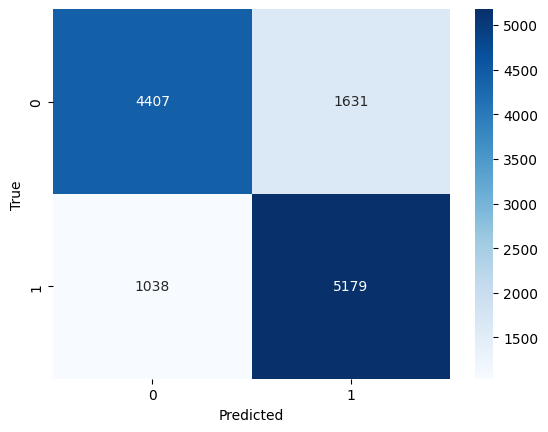

In [39]:
y_predicted = grid_search.best_estimator_.predict(x_test)

metrics(y_predicted, y_test)

### SVM

In [42]:
column_trans = ColumnTransformer(
  transformers=(
    ("StandardScaler", StandardScaler(), numerical_cols),
    ("one_hot_encoder", OneHotEncoder(cols=one_hot_encoder_cols), one_hot_encoder_cols),
    ("drop", "drop", drop_colums)
  ),
  remainder="passthrough"
)

svc_pipeline = Pipeline(
  steps=[
    ("transformer", column_trans),
    ("pca", PCA(n_components=60)),
    ("model", SVC())
  ])

Calculo n_components

In [ ]:
def pca_components():
  x_train_scaled = column_trans.fit_transform(x_train)
  pca = PCA()
  pca.fit(x_train_scaled)
  
  df = pd.DataFrame({
    "n_components": range(1,len(pca.explained_variance_ratio_)+1),
    "explained_variance": np.cumsum(pca.explained_variance_ratio_)
  })
  display(df[(df["explained_variance"] > 0.89) & (df["explained_variance"] < 0.92)])

pca_components()

In [ ]:
params = [{
  'model__kernel': ["linear"],
  "model__C": range(3, 7)
}, {
  'model__kernel': ["poly"],
  "model__C": [5],
  "model__degree": range(9, 12),
  "model__gamma": range(9, 12),
  "model__coef0": range(9, 12)
}, {
  "model__kernel": ['rbf'],
  "model__C": [5],
  "model__gamma": [10, 12]
}]

grid_search = GridSearchCV(
  estimator=svc_pipeline,
  param_grid=params,
  scoring="f1",
  n_jobs=-1,
  cv=5
)

grid_search.fit(x_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"F1 score: {grid_search.best_score_}")